In [20]:
import pandas as pd
import maidenhead as mh
import numpy as np
import os
from datetime import datetime

BRAINS_CSV = '/usr/datalake/silver/stormevents/artifacts/igra_storm_event_autoencoder/brains_station_list.csv'
SEVERE_CSV = '/usr/datalake/silver/stormevents/csvfiles/severe_maidenhead.csv'
IGRA_CSV_PATTERN = '/usr/datalake/silver/stormevents/igra_encoded/{station_id}_igra_encoded.csv'
IGRA_MAIDENHEAD_PATH = '/usr/datalake/silver/stormevents/csvfiles/igra_maidenhead'
MAIDENHEAD = 'EN35'
start_date = datetime(1990, 1, 1)
stop_date = datetime(2025, 5, 30)

In [21]:
os.makedirs(IGRA_MAIDENHEAD_PATH, exist_ok=True)

In [22]:
def get_stations() -> pd.DataFrame:
    result = pd.read_csv(BRAINS_CSV)

    return result

def haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float, earth_radius=6371.0): # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = earth_radius * c
    return distance

def get_closest_stations(lat: float, lon: float, df_source: pd.DataFrame, limit: int) -> tuple[list[str], list[str]]:
    result = df_source.copy()
    result['distance'] = result.apply(lambda x: haversine_distance(x.latitude, x.longitude, lat, lon), axis=1)
    result = result.sort_values(by='distance')
    result = result.iloc[0:limit]

    names = result.apply(lambda x: f'{x['name']} ({x['id']})', axis=1).to_numpy()
    ids = result['id'].to_numpy()

    return ids, names

def get_severe_in_maidenhead(df_source: pd.DataFrame, in_list: list[str]) -> pd.DataFrame:
    result = df_source.copy()
    result['EFFECTIVE'] = pd.to_datetime(result['EFFECTIVE'])
    result = result[result['MAIDENHEAD'].isin(in_list)]
    result = result.drop(labels=['MAIDENHEAD'], axis=1)
    result = result.groupby(by=['EFFECTIVE']).max()
    result.loc[result['TORNADO_SIGNIFICANT'] == 1, 'SEVERE_SIGNIFICANT'] = 0
    result.loc[result['TORNADO_SIGNIFICANT'] == 1, 'SEVERE_MINOR'] = 0
    result.loc[result['SEVERE_SIGNIFICANT'] == 1, 'SEVERE_MINOR'] = 0

    return result

def merge_temporal_severe(df_source: pd.DataFrame, start: datetime, stop: datetime):
    result = pd.DataFrame(pd.date_range(start, stop), columns=['effective'])
    result = result.merge(df_source, how='left', left_on=['effective'], right_on=['EFFECTIVE'])
    result = result.fillna(0)
    result['TORNADO_SIGNIFICANT'] = result['TORNADO_SIGNIFICANT'].astype(int)
    result['SEVERE_SIGNIFICANT'] = result['SEVERE_SIGNIFICANT'].astype(int)
    result['SEVERE_MINOR'] = result['SEVERE_MINOR'].astype(int)
    result['SEVERE_NONE'] = np.zeros(result.shape[0]).astype(int)
    result.loc[(result['TORNADO_SIGNIFICANT'] == 0) & (result['SEVERE_SIGNIFICANT'] == 0) & (result['SEVERE_MINOR'] == 0), 'SEVERE_NONE'] = 1

    return result

def read_igra_by_id(station_id: str) -> pd.DataFrame:
    filename = IGRA_CSV_PATTERN.replace('{station_id}', station_id)
    result = pd.read_csv(filename)
    result['effective_date'] = pd.to_datetime(result['effective_date'])

    return result

def merge_severe_igra(df_igra: pd.DataFrame, df_severe: pd.DataFrame) -> pd.DataFrame:
    result = df_igra.merge(df_severe, how='inner', left_on=['effective_date'], right_on=['effective'])
    result = result.drop(labels=['effective'], axis=1)

    return result

def get_column_names():
    result = [f'{i}' for i in range(-2, 60)]
    result[0] = 'effective_date'
    result[1] = 'day_num'
    result = np.array(result)

    return result

def merge_closest_igras(station_ids: list[str]) -> pd.DataFrame:
    df_igra = [read_igra_by_id(station_ids[i]) for i in range(3)]

    result = pd.merge(left=df_igra[0], right=df_igra[1], how="inner", left_on='effective_date', right_on='effective_date')
    result = pd.merge(left=result, right=df_igra[2], how="inner", left_on='effective_date', right_on='effective_date')
    result = result.drop(labels=['day_num', 'day_num_y'], axis=1)
    result.columns = get_column_names()

    return result

In [23]:
station_df = get_stations()
station_df.head()

,id,latitude,longitude,elevation,state,name,fst_year,lst_year,nobs
0,BBM00078954,13.0716,-59.4922,56.6,NaN,GRANTLEY ADAMS,1965,2025,31817
1,BHM00078583,17.5333,-88.3000,5.0,NaN,BELIZE/PHILLIP GOLDSTON INTL.,1980,2025,21481
2,CJM00078384,19.2944,-81.3632,3.0,NaN,OWEN ROBERTS AIRPORT GRAND CAY,1956,2025,37597
3,COM00080001,12.5833,-81.7167,1.0,NaN,SAN ANDRES (ISLA)/SESQUICENTEN,1956,2025,27604
4,DRM00078486,18.4734,-69.8705,14.0,NaN,SANTO DOMINGO (78486-0),1962,2025,28418


In [24]:
lat, lon = mh.to_location(MAIDENHEAD, True)
print (f'Maidenhead {MAIDENHEAD}: ({lat:.2f}, {lon:.2f})')

Maidenhead EN35: (45.50, -93.00)


In [25]:
station_ids, station_names = get_closest_stations(lat, lon, station_df, 3)
print(f'Closest stations: {', '.join(station_names)}')

Closest stations: CHANHASSEN; MN. (USM00072649), INT.FALLS/FALLS INT. MN. (USM00072747), GREEN BAY/A.-STRAUBEL; WI. (USM00072645)


In [26]:
df_igra = merge_closest_igras(station_ids)
df_igra.head()

,effective_date,day_num,0,1,2,3,4,5,6,7,...,50,51,52,53,54,55,56,57,58,59
0,2000-01-02,-1.00,-0.417757,-0.045148,-0.013715,-0.277452,0.138187,0.180632,-0.136137,0.127814,...,0.209417,0.100948,-0.328473,0.163579,0.001896,-0.003187,-0.058521,-0.175127,0.024591,-0.239993
1,2000-01-03,-1.00,-0.452206,0.027811,0.042108,-0.254606,0.058706,0.267822,-0.206661,0.068196,...,0.140689,-0.111453,-0.086357,0.215060,-0.054715,0.082105,-0.199595,-0.006018,0.045081,-0.040863
2,2000-01-04,-1.00,-0.397071,-0.157910,0.209536,-0.034484,0.023554,0.037854,-0.252053,-0.104660,...,0.166175,-0.076837,0.037259,0.115951,-0.070943,0.398693,0.103478,-0.220919,-0.043549,-0.078604
3,2000-01-06,-0.99,-0.454803,0.015692,0.190677,0.002125,-0.094822,-0.209260,-0.243773,-0.078310,...,0.099667,0.123847,-0.056329,0.008823,-0.068612,0.116502,-0.059661,-0.293259,-0.074837,0.018446
4,2000-01-08,-0.99,-0.394696,0.054686,0.123557,-0.053164,-0.022552,-0.050661,-0.161673,0.057743,...,0.157548,0.029032,-0.198752,-0.121043,0.025166,0.105063,-0.095534,-0.226631,-0.046101,0.032923


In [27]:
df_severe = get_severe_in_maidenhead(pd.read_csv(SEVERE_CSV), [MAIDENHEAD])
df_severe = merge_temporal_severe(df_severe, start_date, stop_date)
df_severe = merge_severe_igra(df_igra, df_severe)
print(df_severe.shape)
df_severe.head()

(6699, 66)


,effective_date,day_num,0,1,2,3,4,5,6,7,...,54,55,56,57,58,59,TORNADO_SIGNIFICANT,SEVERE_SIGNIFICANT,SEVERE_MINOR,SEVERE_NONE
0,2000-01-02,-1.00,-0.417757,-0.045148,-0.013715,-0.277452,0.138187,0.180632,-0.136137,0.127814,...,0.001896,-0.003187,-0.058521,-0.175127,0.024591,-0.239993,0,0,0,1
1,2000-01-03,-1.00,-0.452206,0.027811,0.042108,-0.254606,0.058706,0.267822,-0.206661,0.068196,...,-0.054715,0.082105,-0.199595,-0.006018,0.045081,-0.040863,0,0,0,1
2,2000-01-04,-1.00,-0.397071,-0.157910,0.209536,-0.034484,0.023554,0.037854,-0.252053,-0.104660,...,-0.070943,0.398693,0.103478,-0.220919,-0.043549,-0.078604,0,0,0,1
3,2000-01-06,-0.99,-0.454803,0.015692,0.190677,0.002125,-0.094822,-0.209260,-0.243773,-0.078310,...,-0.068612,0.116502,-0.059661,-0.293259,-0.074837,0.018446,0,0,0,1
4,2000-01-08,-0.99,-0.394696,0.054686,0.123557,-0.053164,-0.022552,-0.050661,-0.161673,0.057743,...,0.025166,0.105063,-0.095534,-0.226631,-0.046101,0.032923,0,0,0,1


<Axes: >

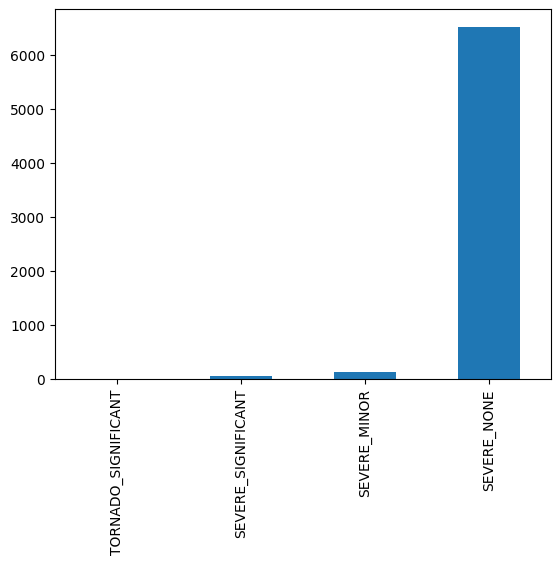

In [28]:
df_severe[['TORNADO_SIGNIFICANT', 'SEVERE_SIGNIFICANT', 'SEVERE_MINOR', 'SEVERE_NONE']].sum().plot(kind='bar')

In [29]:
df_severe.to_csv(f'{IGRA_MAIDENHEAD_PATH}/{MAIDENHEAD}.csv', index=False)